## Getting the data

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alkalinity of ash', 'Magnesium', 'Phenolic content',
                  'Flavonoids', 'Non-flavonoid phenols', 'Proanthocyanidins', 'Color intensity', 'Shade',
                   'Transmittancy 280/315 nm', 'Proline']

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

stds = StandardScaler()
X_train_std = stds.fit_transform(X_train)
X_test_std = stds.transform(X_test)

## Mean vectors

In [2]:
import numpy as np

np.set_printoptions(precision=4)
mean_vecs = []
for label in np.unique(y_train):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[-1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



## Within-class scatter matrix

In [3]:
d = X_train_std.shape[1]
S_W = np.zeros((d, d))
for label, mv in zip(np.unique(y_train), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train==label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter
    
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [4]:
## Verify that class labels are not equally distributed:
np.bincount(y_train)[1:]

array([40, 49, 35])

We need to scale the scatter matrices for particular classes; we do it by multiplying them by $\frac{1}{N_i}$, where $N_i$ is number of elements of $i$th class. Note, that scaled scatter matrix is actually the covariance matrix.

In [5]:
d = X_train_std.shape[1]
S_W = np.zeros((d, d))
for label, mv in zip(np.unique(y_train), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
    
print('Scaled within-class scatter matrix (or just covariance matrix): %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix (or just covariance matrix): 13x13


## Between-classes scatter matrix

In [6]:
d = X_train_std.shape[1]
mean_overall = np.mean(X_train_std, axis=0).reshape(d, 1)
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    S_B += n*(mean_vec-mean_overall).dot((mean_vec-mean_overall).T)

print("Between-classes scatter matrix: %sx%s" % (S_B.shape[0], S_B.shape[1]))

Between-classes scatter matrix: 13x13


## Linear discriminants selection for new features subspace

In [7]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [8]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print('Eigenvalues in descending order:')
for p in eigen_pairs:
    print(p[0])

Eigenvalues in descending order:
452.72158124497446
156.43636121952323
7.055750442664273e-14
5.684341886080802e-14
3.411292331606776e-14
3.407972295227485e-14
3.407972295227485e-14
1.1677556537166565e-14
1.1677556537166565e-14
8.59477909860908e-15
8.59477909860908e-15
4.245233614355452e-15
2.6858909628980554e-15


Note: the results (especially from 3rd line down) are different from what you could find in the book; probably due to some differces in floating-point arithmetics (note, that they are really small values). BUT, fortunately, it doesn't really matter, because we will not utilize them

## Let's visualize the actual impact of particular linear discriminant ("distinguishability" - term from the book):

In [9]:
import matplotlib.pyplot as plt

tot = sum(eigen_vals.real) # well, because not all of them have imaginary part equal to zero
discr = [(ev/tot) for ev in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='single "distinguishability"')
plt.step(range(1, 14), cum_discr, where='mid', label='Cumulative "distinguishability"')
plt.ylabel('"distinguishability" coefficient')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 1 Axes>

## Let's do the transformation and obtain new subspace of features:

In [10]:
# W matrix (transformation matrix)
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('W matrix:\n', w)

W matrix:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


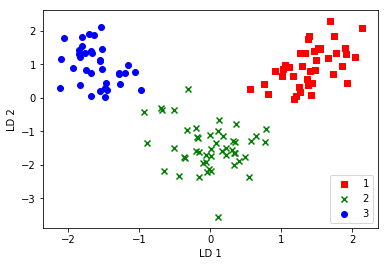

In [11]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'g', 'b']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    ind = y_train==l
    plt.scatter(X_train_lda[ind, 0]*(-1), X_train_lda[ind, 1]*(-1), c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show()

# All of the above in scikit-learn:

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

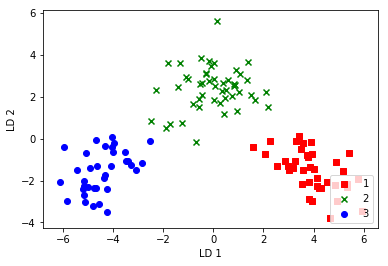

In [13]:
for l, c, m in zip(np.unique(y_train), colors, markers):
    ind = y_train==l
    plt.scatter(X_train_lda[ind, 0]*(-1), X_train_lda[ind, 1]*(-1), c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show()

## Let's check, how Logistic Regression will perform on new feature space:

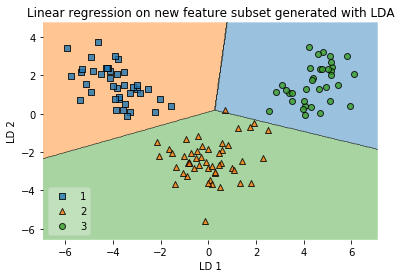

In [16]:
from sklearn.linear_model import LogisticRegression
from my_plotter import plot_regions

lr = LogisticRegression()
lr.fit(X_train_lda, y_train)
plot_regions(X_train_lda, y_train, lr, 'LD 1', 'LD 2',
             'Linear regression on new feature subset generated with LDA', 3)